In [1]:
from rdflib import Graph

g = Graph()
g.parse("maize-kg-exp.ttl", format="turtle")

edges = []

for s, p, o in g:
    if "maize-kg" in str(s) and "maize-kg" in str(o):
        edges.append((str(s), str(p), str(o)))

print("Total edges:", len(edges))

import csv
with open("edge_list.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["source", "relation", "target"])
    writer.writerows(edges)

Total edges: 731


In [2]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec

df = pd.read_csv("edge_list.csv")
G = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.Graph())

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, workers=2)
model = node2vec.fit(window=10, min_count=1)

model.wv.save_word2vec_format("embedding.vec")

Computing transition probabilities:   0%|          | 0/144 [00:00<?, ?it/s]

In [6]:
import pandas as pd

path = "embedding.vec"

with open(path, "r", encoding="utf-8") as f:
    header = f.readline().strip().split()
    n_nodes, dim = int(header[0]), int(header[1])

rows = []
with open(path, "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.strip().split()
        node = parts[0]
        vector = list(map(float, parts[1:]))
        rows.append([node] + vector)

cols = ["node"] + [f"dim_{i+1}" for i in range(dim)]
df = pd.DataFrame(rows, columns=cols)

print(df.head())

                                                node     dim_1     dim_2  \
0           http://example.org/maize-kg#Pengendalian -0.554421 -0.022645   
1         http://example.org/maize-kg#MasalahTanaman  0.154757 -0.096721   
2                 http://example.org/maize-kg#Jagung  0.259570 -0.055684   
3  http://example.org/maize-kg#Maize_Chlorotic_Mo...  0.303113 -0.084164   
4                   http://example.org/maize-kg#daun -0.008509 -0.201368   

      dim_3     dim_4     dim_5     dim_6     dim_7     dim_8     dim_9  ...  \
0  0.290846  0.180208 -0.183968  0.190425 -0.193447  0.257543 -0.298631  ...   
1  0.226412 -0.053528 -0.048214 -0.123027  0.163896  0.016944  0.133091  ...   
2  0.239748  0.248604 -0.012135 -0.039086 -0.028868  0.002502 -0.139594  ...   
3  0.136935  0.006886 -0.212125 -0.118359  0.049776 -0.256394 -0.351787  ...   
4  0.242746 -0.068070  0.082308 -0.144221  0.246481  0.067676 -0.277139  ...   

     dim_55    dim_56    dim_57    dim_58    dim_59    dim_60 

In [7]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

v_pengendalian = df[df["node"]=="http://example.org/maize-kg#Pengendalian"].iloc[0,1:].values
v_masalah = df[df["node"]=="http://example.org/maize-kg#MasalahTanaman"].iloc[0,1:].values
v_jagung = df[df["node"]=="http://example.org/maize-kg#Jagung"].iloc[0,1:].values

print("cos(Pengendalian, MasalahTanaman) =", cos_sim(v_pengendalian, v_masalah))
print("cos(Pengendalian, Jagung)         =", cos_sim(v_pengendalian, v_jagung))
print("cos(MasalahTanaman, Jagung)       =", cos_sim(v_masalah, v_jagung))

cos(Pengendalian, MasalahTanaman) = 0.2482726543798333
cos(Pengendalian, Jagung)         = 0.1544960890688266
cos(MasalahTanaman, Jagung)       = 0.4882875738070008


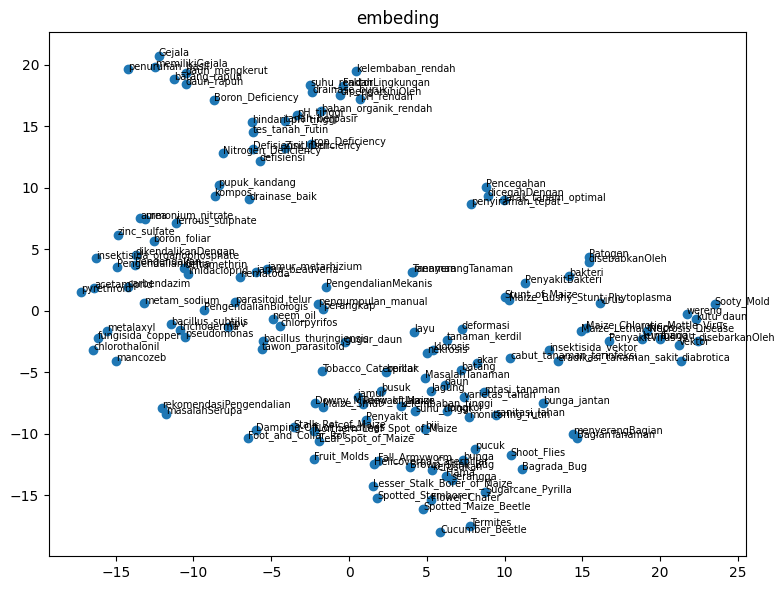

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = df.iloc[:,1:].values
nodes = df["node"].values

X_2d = TSNE(n_components=2, perplexity=15, random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1])

def short(x):
    return x.split("#")[-1]

for i, node in enumerate(nodes):
    plt.annotate(short(node), (X_2d[i,0], X_2d[i,1]), fontsize=7)

plt.title("embeding")
plt.tight_layout()
plt.show()